In [79]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
import csv

## Useful code to me but less useful to the visualizing of the final results

In [64]:
PAPER_TRAIL_CAPTURE_PATTERN = re.compile(r"```((?:.|\n)+)```")
PAPER_TRAIL_TRUNCATED_PATTERN = re.compile(r"({(?:.|\n)+?})")
BOOKING_TYPE_PATTERN = re.compile(r"\*Booking Type:\*\s+(\w+)\b")
BOOKING_ID_PATTERN = re.compile(r"\*Booking ID:\*\s+(\w+)\b")
PROVIDER_PATTERN = re.compile(r"\*Provider:\*\s+(\w+)\b")

def _handle_truncated_pattern(text):
    # We have a truncated message. Try to get something reasonable out of it
    # Match any complete json object I can find. Initial looking suggests the second error is the useful one
    for match in PAPER_TRAIL_TRUNCATED_PATTERN.finditer(text):
        try:
            error = json.loads(match.group(1))
            return {'error_class': error['class'], 'error_key': error['key']}
        except ValueError:
            # Did not match
            continue
    raise ValueError("Did not find an error")

def _parse_error(message):
    try:
        match = PAPER_TRAIL_CAPTURE_PATTERN.search(message['text']).group(1)
    except AttributeError:
        # This means my regex did not match which best I can tell happens when the message was truncated
        return _handle_truncated_pattern(message['text'])
    message_json = json.loads(match)
    
    # magic! Im simplifying by focusing on only one of many errors that get reported at once. In general
    # these are based on inspection... but if you are here skeptical. then this is where
    # to start looking. 
    if len(message_json) == 1 or message_json[0].get('class') == 'car-error':
        important_error = message_json[0]
    else:
        important_error = message_json[1]
    return {'error_class': important_error['class'], 
            'error_key': important_error['key']}
    
def _extract_criticality(message):
    if message.get('username') == "Booking Failures [Critical]":
        return 'Critical'
    elif message.get('username') == "Booking Failures [Non-Critical]":
        return 'Non-Critical'
    else:
        return 'Unclassified'
        
def extract_error_details(message):
    message_attachment = message['attachments'][0]
    error_details = _parse_error(message_attachment)
    error_details.update(
        {
            'status': _extract_criticality(message),
            'provider': PROVIDER_PATTERN.search(message_attachment['text']).group(1),
            'booking_type': BOOKING_TYPE_PATTERN.search(message_attachment['text']).group(1),
            'booking_id': BOOKING_ID_PATTERN.search(message_attachment['text']).group(1)
        }
    )
    return error_details

def plot_counter(counter, title):
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(10,10)
    plt.title(title, y=1.04)
    ax1.pie(
        [s[1] for s in counter.items()], 
        labels=[s[0] for s in counter.items()], 
        autopct='%1.1f%%', 
        shadow=True, 
        startangle=90
    )
    ax1.axis('equal')

    plt.show()

In [65]:
with open('channel_history.json') as infile:
    channel_history = json.load(infile)

In [66]:
len(channel_history)

8972

## Lets parse the chats and filter out messages before:  Friday, November 22, 2019

I am also filtering out Sumo Logic alerts. They all seem to be "Abiguous Phone Number" which stopped happening in december

In [67]:
channel_history = [
    extract_error_details(message) for message in channel_history 
    if message.get('subtype') == 'bot_message' 
    and float(message['ts']) > 1574380800
    and message['username'] != 'Sumo Logic'
]

In [68]:
len(channel_history)

1254

## Now we are looking at Friday, November 22, 2019 - Wednesday, January 22, 2020 

## Error Status

In [7]:
status_counter = Counter([x['status'] for x in channel_history])

In [8]:
status_counter.most_common(3)

[('Critical', 892), ('Non-Critical', 362)]

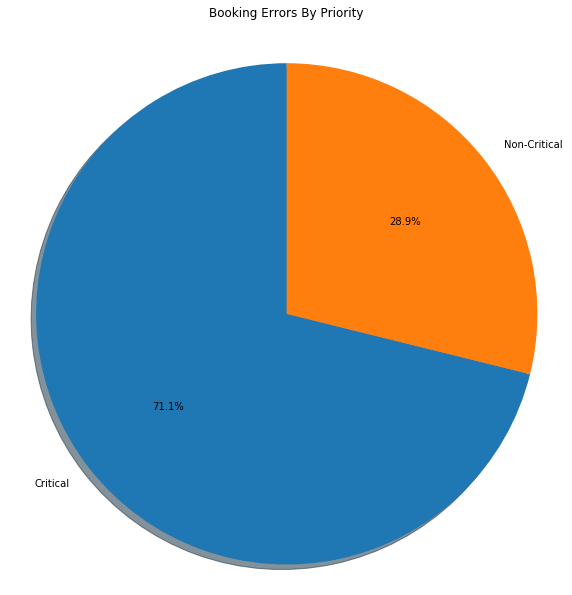

In [9]:
plot_counter(status_counter, "Booking Errors By Priority")

## Error Breakdown by provider

In [10]:
provider_counter = Counter([x['provider'] for x in channel_history])

In [11]:
provider_counter.most_common(50)

[('amadeus', 424),
 ('priceline', 414),
 ('sabre', 301),
 ('ean_rapid', 61),
 ('ean', 54)]

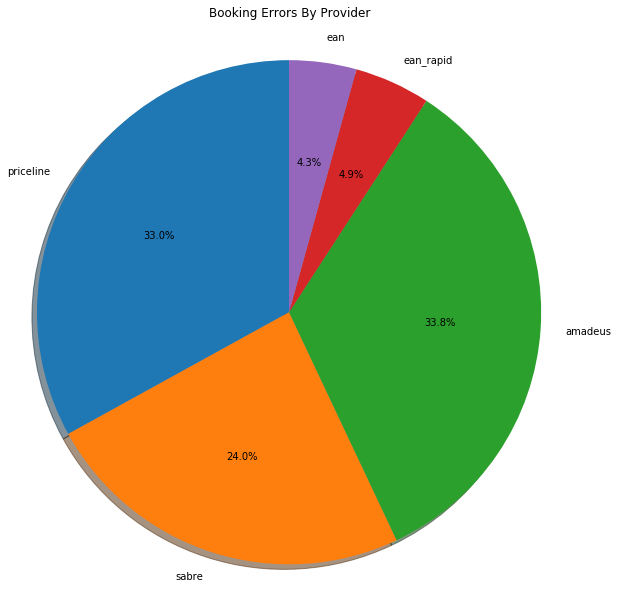

In [12]:
plot_counter(provider_counter, "Booking Errors By Provider")

## Error By Booking Type

In [13]:
booking_type_counter = Counter([x['booking_type'] for x in channel_history])

In [14]:
booking_type_counter.most_common(50)

[('Flight', 689), ('Hotel', 509), ('Car', 56)]

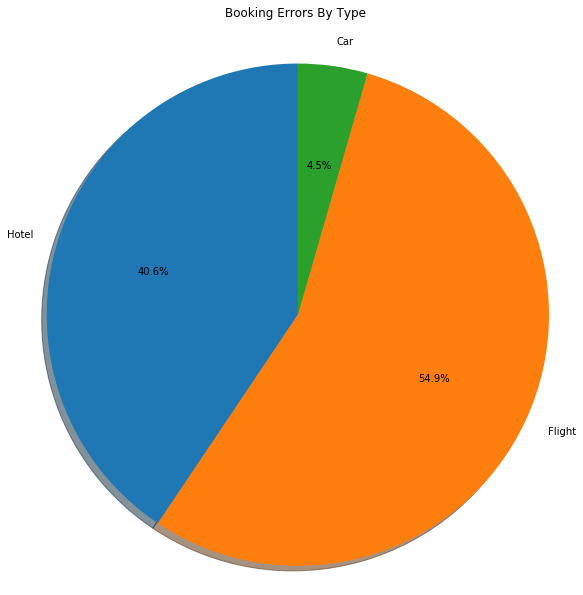

In [15]:
plot_counter(booking_type_counter, "Booking Errors By Type")

# Investigating Flight Errors

Errors typically have a class and a key. The class represents the "type" of error while the key tends to be more fine grained within that class.

Some example *classes* include *ProviderError*, and *PaymentError*

Each key has a series of *keys* (I will use the word subtype going forward) so for PaymentError some keys include *DECLINED* or *ADD_BATCHED_CC_INFO_FAILED*

subtypes are more fine grained but to uniquely identify an error you need both


In [16]:
flight_errors = [x for x in channel_history if x['booking_type'] == 'Flight']

In [17]:
error_counter = Counter([f"{x['error_class']}" for x in flight_errors])
key_counter = Counter([f"{x['error_key']}" for x in flight_errors])
combined_error_counter = Counter([f"{x['error_class']} - {x['error_key']}" for x in flight_errors])

## Flight Errors By Provider

In [18]:
provider_counter = Counter([f"{x['provider']}" for x in flight_errors])

In [19]:
provider_counter.most_common(50)

[('amadeus', 424), ('sabre', 265)]

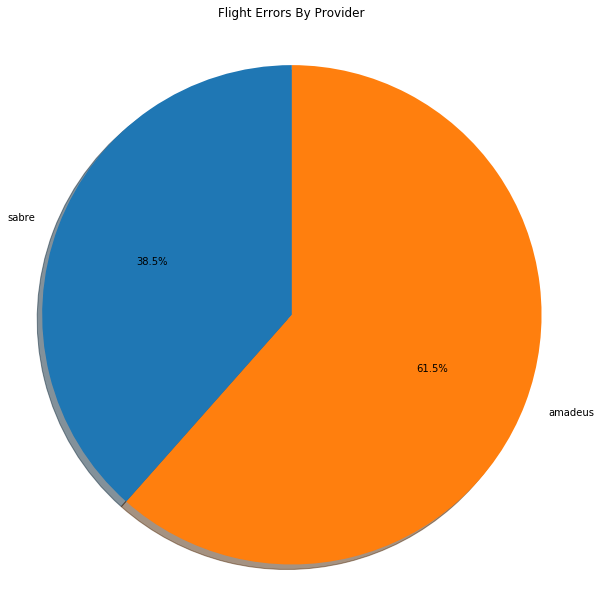

In [20]:
plot_counter(provider_counter, "Flight Errors By Provider")

## Flight Error Types

In [21]:
error_counter.most_common(50)

[('ProviderError', 204),
 ('PaymentError', 197),
 ('PricingError', 104),
 ('AvailabilityError', 77),
 ('PaymentValidationError', 43),
 ('ResultParsingError', 22),
 ('InternalError', 21),
 ('RequestHelpClientError', 10),
 ('InternalFraudError', 7),
 ('ConnectionError', 2),
 ('ReadTimeout', 2)]

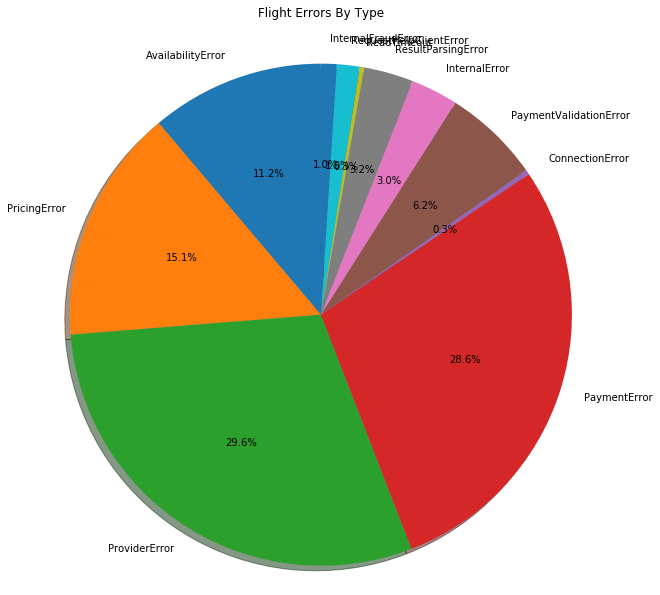

In [22]:
plot_counter(error_counter, "Flight Errors By Type")

## Flight Error subtypes

In [23]:
key_counter.most_common(50)

[('DECLINED', 189),
 ('MISMATCH', 104),
 ('UNKNOWN', 96),
 ('SOLD_OUT', 77),
 ('INVALID_BILLING_ADDRESS', 75),
 ('ADD_FOP_FAILED', 46),
 ('INVALID_BILLING_INFO', 41),
 ('ADD_BATCHED_CC_INFO_FAILED', 15),
 ('AIRLINE_LINK_DELAY', 11),
 ('HELP', 10),
 ('PAID_SEAT_NOT_SUPPORTED', 9),
 ('INTERNAL_FRAUD_ALERT', 7),
 ('None', 4),
 ('INTERNAL_ERROR', 3),
 ('INVALID_BILLING_ZIPCODE', 2)]

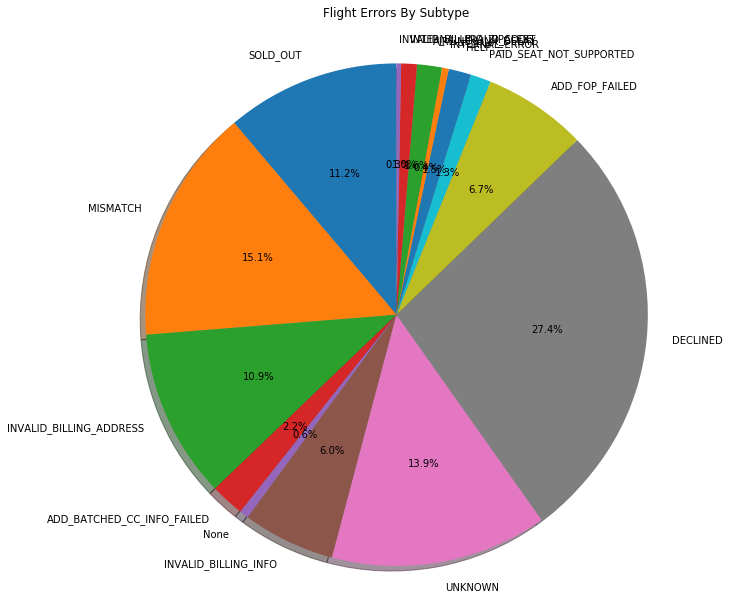

In [24]:
plot_counter(key_counter, "Flight Errors By Subtype")

## Flight Error Type and Subtype Combos

In [25]:
combined_error_counter.most_common(50)

[('PaymentError - DECLINED', 182),
 ('PricingError - MISMATCH', 104),
 ('AvailabilityError - SOLD_OUT', 77),
 ('ProviderError - INVALID_BILLING_ADDRESS', 75),
 ('ProviderError - UNKNOWN', 56),
 ('ProviderError - ADD_FOP_FAILED', 46),
 ('PaymentValidationError - INVALID_BILLING_INFO', 41),
 ('ResultParsingError - UNKNOWN', 22),
 ('InternalError - UNKNOWN', 18),
 ('PaymentError - ADD_BATCHED_CC_INFO_FAILED', 15),
 ('ProviderError - AIRLINE_LINK_DELAY', 11),
 ('RequestHelpClientError - HELP', 10),
 ('ProviderError - PAID_SEAT_NOT_SUPPORTED', 9),
 ('ProviderError - DECLINED', 7),
 ('InternalFraudError - INTERNAL_FRAUD_ALERT', 7),
 ('InternalError - INTERNAL_ERROR', 3),
 ('ConnectionError - None', 2),
 ('ReadTimeout - None', 2),
 ('PaymentValidationError - INVALID_BILLING_ZIPCODE', 2)]

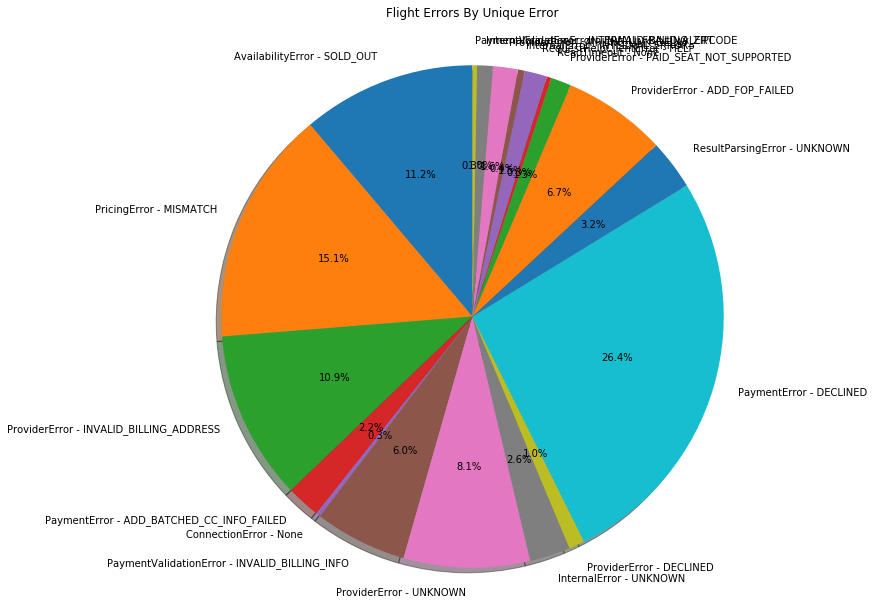

In [26]:
plot_counter(combined_error_counter, "Flight Errors By Unique Error")

# Investigating Hotel Errors

Errors typically have a class and a key. The class represents the "type" of error while the key tends to be more fine grained within that class.

Some example *classes* include *ProviderError*, and *PaymentError*

Each key has a series of *keys* (I will use the word subtype going forward) so for PaymentError some keys include *DECLINED* or *ADD_BATCHED_CC_INFO_FAILED*

subtypes are more fine grained but to uniquely identify an error you need both


In [27]:
hotel_errors = [x for x in channel_history if x['booking_type'] == 'Hotel']

In [28]:
error_counter = Counter([f"{x['error_class']}" for x in hotel_errors])
key_counter = Counter([f"{x['error_key']}" for x in hotel_errors])
combined_error_counter = Counter([f"{x['error_class']} - {x['error_key']}" for x in hotel_errors])

## Hotel Errors By Provider

In [29]:
provider_counter = Counter([f"{x['provider']}" for x in hotel_errors])

In [30]:
provider_counter.most_common(50)

[('priceline', 358), ('ean_rapid', 61), ('ean', 54), ('sabre', 36)]

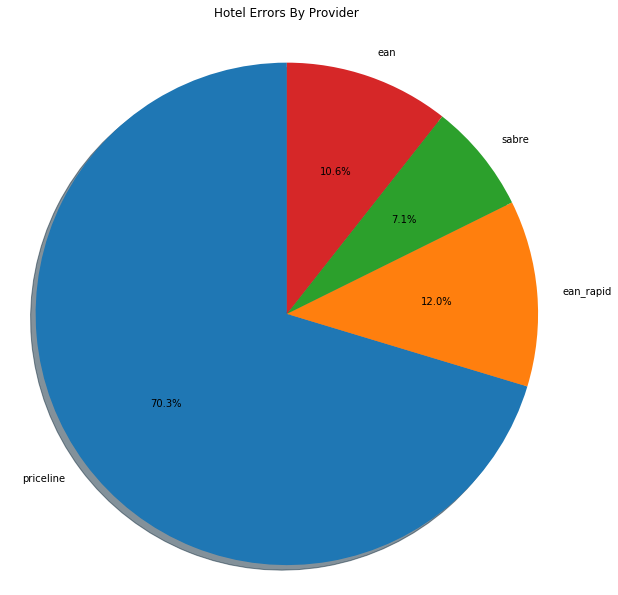

In [31]:
plot_counter(provider_counter, "Hotel Errors By Provider")

## Hotel Error Types

In [32]:
error_counter.most_common(50)

[('BookingError', 158),
 ('ProviderError', 156),
 ('AvailabilityError', 90),
 ('InternalDataValidationError', 28),
 ('PaymentError', 26),
 ('RequestHelpClientError', 19),
 ('PaymentValidationError', 16),
 ('InternalError', 7),
 ('InternalFraudError', 4),
 ('ResultParsingError', 2),
 ('ReadTimeout', 2),
 ('AttributeError', 1)]

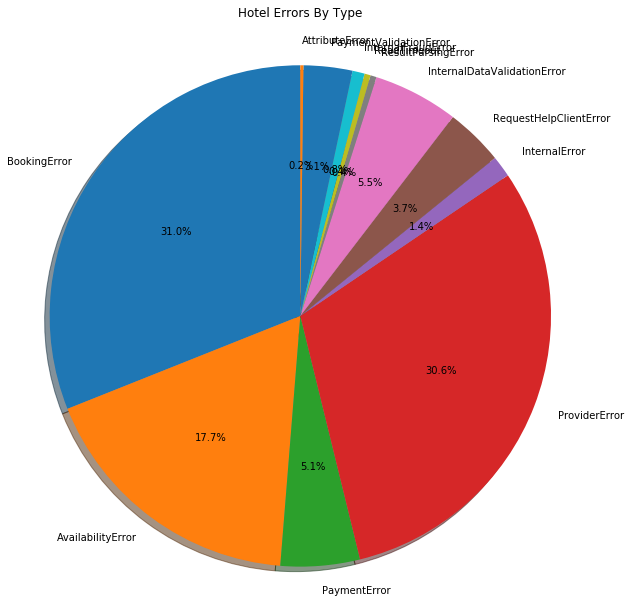

In [33]:
plot_counter(error_counter, "Hotel Errors By Type")

## Hotel Error subtypes

In [34]:
key_counter.most_common(50)

[('UNKNOWN', 166),
 ('UNKNOWN_CREDIT_CARD_FAILURE', 100),
 ('SOLD_OUT', 90),
 ('UNKNOWN_STATUS', 46),
 ('VALIDATION', 28),
 ('DECLINED', 25),
 ('CC_CVV', 16),
 ('ALREADY_BOOKED', 10),
 ('TIMEOUT', 8),
 ('INTERNAL_ERROR', 7),
 ('INTERNAL_FRAUD_ALERT', 4),
 ('None', 3),
 ('RETRIEVE_CONTRACT_FAILED', 2),
 ('HELP', 1),
 ('FRAUD_ALERT', 1),
 ('CONNECTION', 1),
 ('AUTHORIZATION', 1)]

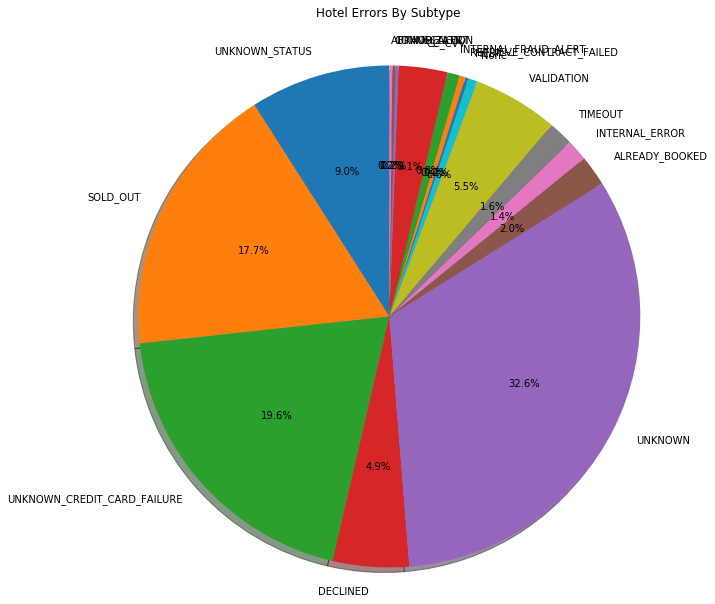

In [35]:
plot_counter(key_counter, "Hotel Errors By Subtype")

## Hotel Error Type and Subtype Combos

In [36]:
combined_error_counter.most_common(50)

[('ProviderError - UNKNOWN', 155),
 ('BookingError - UNKNOWN_CREDIT_CARD_FAILURE', 100),
 ('AvailabilityError - SOLD_OUT', 90),
 ('BookingError - UNKNOWN_STATUS', 46),
 ('InternalDataValidationError - VALIDATION', 28),
 ('PaymentError - DECLINED', 25),
 ('PaymentValidationError - CC_CVV', 16),
 ('BookingError - ALREADY_BOOKED', 10),
 ('RequestHelpClientError - UNKNOWN', 9),
 ('RequestHelpClientError - TIMEOUT', 8),
 ('InternalError - INTERNAL_ERROR', 7),
 ('InternalFraudError - INTERNAL_FRAUD_ALERT', 4),
 ('ResultParsingError - UNKNOWN', 2),
 ('ReadTimeout - None', 2),
 ('BookingError - RETRIEVE_CONTRACT_FAILED', 2),
 ('RequestHelpClientError - HELP', 1),
 ('PaymentError - FRAUD_ALERT', 1),
 ('RequestHelpClientError - CONNECTION', 1),
 ('AttributeError - None', 1),
 ('ProviderError - AUTHORIZATION', 1)]

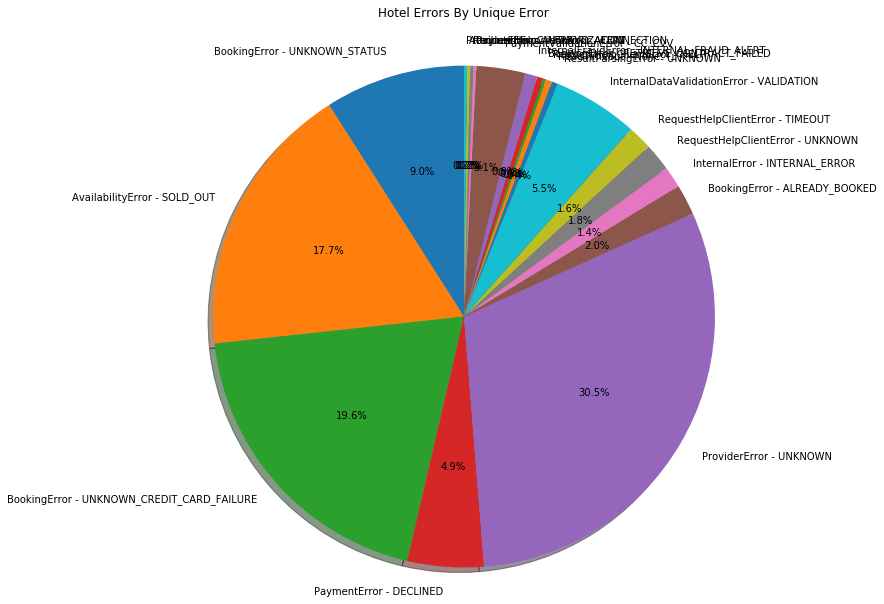

In [37]:
plot_counter(combined_error_counter, "Hotel Errors By Unique Error")

# Investigating Cars Errors

Errors typically have a class and a key. The class represents the "type" of error while the key tends to be more fine grained within that class.

Some example *classes* include *ProviderError*, and *PaymentError*

Each key has a series of *keys* (I will use the word subtype going forward) so for PaymentError some keys include *DECLINED* or *ADD_BATCHED_CC_INFO_FAILED*

subtypes are more fine grained but to uniquely identify an error you need both


In [38]:
car_errors = [x for x in channel_history if x['booking_type'] == 'Car']

In [39]:
error_counter = Counter([f"{x['error_class']}" for x in car_errors])
key_counter = Counter([f"{x['error_key']}" for x in car_errors])
combined_error_counter = Counter([f"{x['error_class']} - {x['error_key']}" for x in car_errors])

## Car Errors By Provider

In [40]:
provider_counter = Counter([f"{x['provider']}" for x in car_errors])

In [41]:
provider_counter.most_common(50)

[('priceline', 56)]

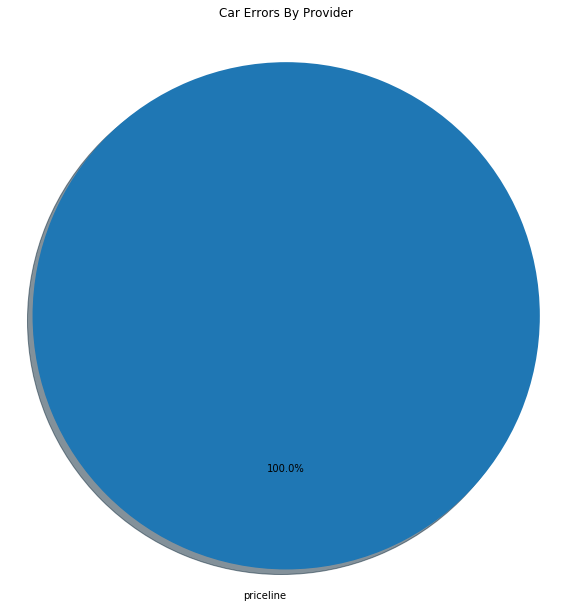

In [42]:
plot_counter(provider_counter, "Car Errors By Provider")

## Car Error Types

In [43]:
error_counter.most_common(50)

[('car-error', 56)]

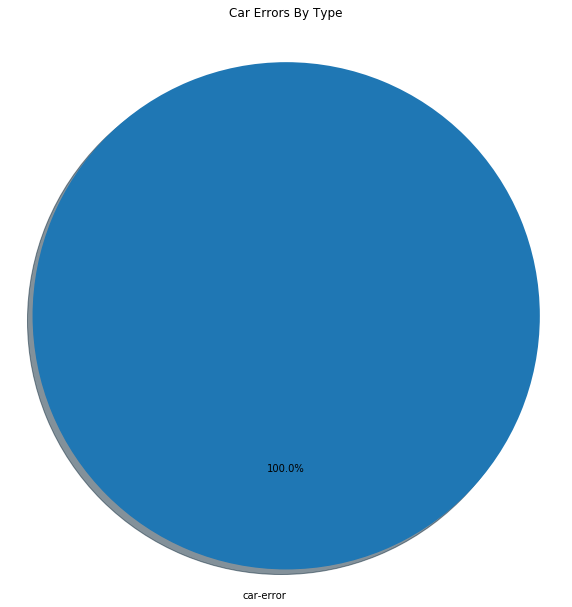

In [44]:
plot_counter(error_counter, "Car Errors By Type")

## Car Error subtypes

In [45]:
key_counter.most_common(50)

[('CAR_BOOKING_UNKNOWN_API_ERROR', 16),
 ('PRICELINE_API', 12),
 ('CAR_BOOKING_CC_DECLINED_ERROR', 11),
 ('CAR_BOOKING_REJECTED', 11),
 ('None', 3),
 ('CAR_CANCEL_UNKNOWN_ERROR', 2),
 ('CAR_BOOKING_UNKNOWN_ERROR', 1)]

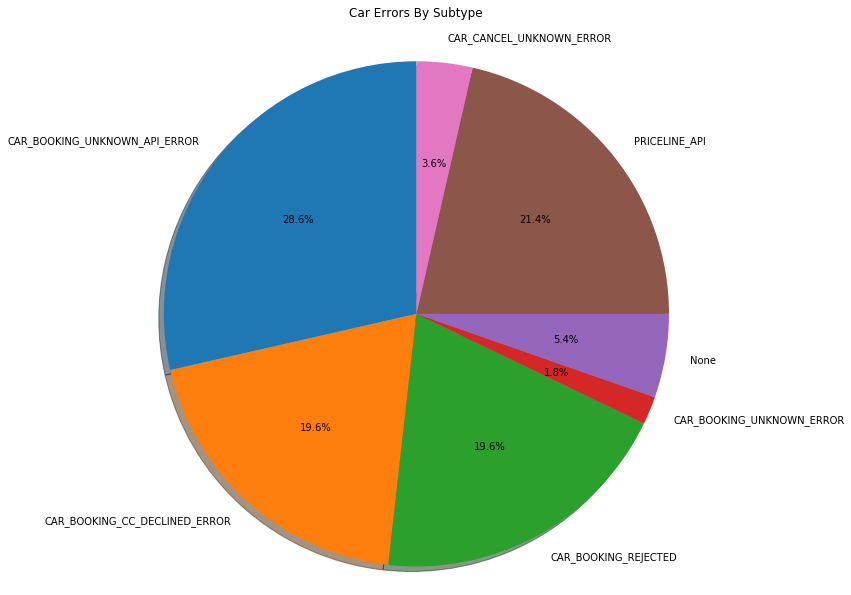

In [46]:
plot_counter(key_counter, "Car Errors By Subtype")

## Car Error Type and Subtype Combos

In [47]:
combined_error_counter.most_common(50)

[('car-error - CAR_BOOKING_UNKNOWN_API_ERROR', 16),
 ('car-error - PRICELINE_API', 12),
 ('car-error - CAR_BOOKING_CC_DECLINED_ERROR', 11),
 ('car-error - CAR_BOOKING_REJECTED', 11),
 ('car-error - None', 3),
 ('car-error - CAR_CANCEL_UNKNOWN_ERROR', 2),
 ('car-error - CAR_BOOKING_UNKNOWN_ERROR', 1)]

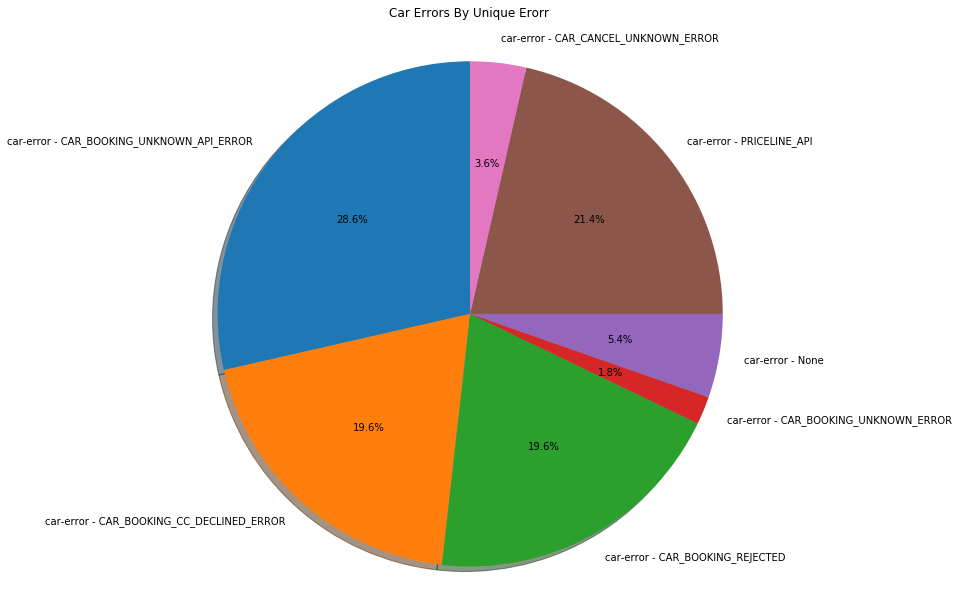

In [48]:
plot_counter(combined_error_counter, "Car Errors By Unique Erorr")

# Deep Dive Into Payment Errors

In [135]:
def is_payment_error(error):
    return (
        error['error_class'] in {"PaymentError", "PaymentValidationError"} 
           or 
        error['error_key'] == 'UNKNOWN_CREDIT_CARD_FAILURE'
        or (error['error_class'] == 'car-error' and error['error_key'] == 'CAR_BOOKING_CC_DECLINED_ERROR')
    )

AMERICAN_EXPRESS = 'AX'
DINERS_CLUB = 'DC'
DISCOVER = 'DS'
MASTERCARD = 'CA'
VISA = 'VI'
JCB = 'JC'
LOLA = 'LOLA'  # used for wombat 'other' card for manual imports

PAYMENT_SUB_TYPE_TO_NAME = {
    'AX': 'AMERICAN_EXPRESS',
    'DC': 'DINERS_CLUB',
    'DS': 'DISCOVER',
    'CA': 'MASTERCARD',
    'VI': 'VISA',
    'JC': 'JCB',
    'LOLA': 'LOLA'
}

## First, lets look at bookings and cards in aggregate

This is a result of running the following query on the db
```sql
select count(*), payment_sub_type
from (
    select bookings.id, payment_sub_type
    from lola_000.bookings
    inner join lola_billing.payment_accounts ON bookings.payment_account_id = payment_accounts.id
    where bookings.deleted = false
    and bookings.created > '11-22-2019' and bookings.created < '01-23-2020'
    and booking_status in ('booked', 'cancelled')
) sub
group by payment_sub_type;

```


In [136]:
card_counts_in_successful_bookings = {
    'DISCOVER': 27,
    'LOLA': 1051,
    'MASTERCARD': 3814,
    'VISA': 4130,
    'AMERICAN_EXPRESS': 6879
}

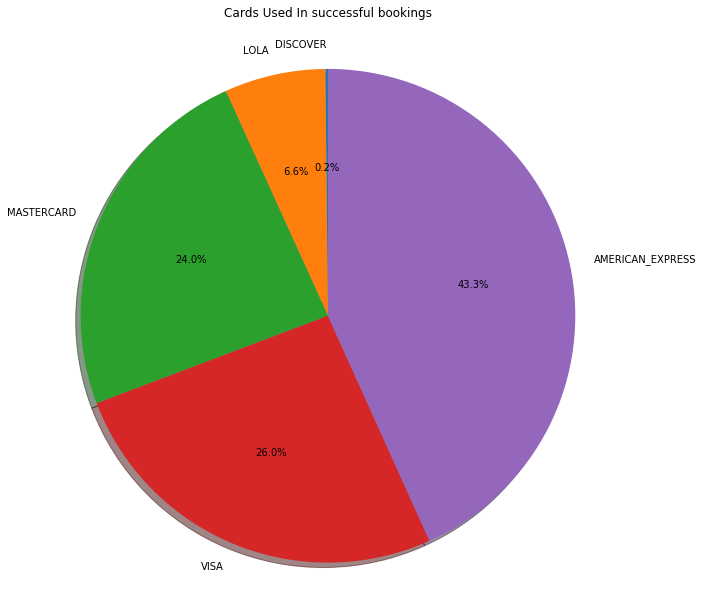

In [137]:
plot_counter(card_counts_in_successful_bookings, "Cards Used In successful bookings")

In [159]:
payment_errors = [x for x in channel_history if is_payment_error(x)]

In [160]:
len(payment_errors)

393

In [161]:
payment_error_counter = Counter([f"{x['error_key']}" for x in payment_errors])

In [162]:
payment_error_counter.most_common(50)

[('DECLINED', 207),
 ('UNKNOWN_CREDIT_CARD_FAILURE', 100),
 ('INVALID_BILLING_INFO', 41),
 ('CC_CVV', 16),
 ('ADD_BATCHED_CC_INFO_FAILED', 15),
 ('CAR_BOOKING_CC_DECLINED_ERROR', 11),
 ('INVALID_BILLING_ZIPCODE', 2),
 ('FRAUD_ALERT', 1)]

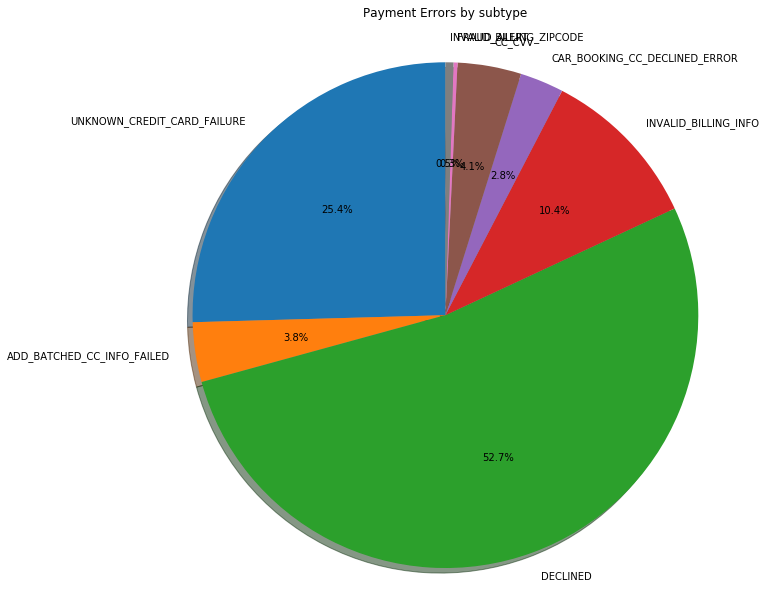

In [163]:
plot_counter(payment_error_counter, "Payment Errors by subtype")

## For this next step I ran a db query to get the payment types for each booking in the errors

In [164]:
booking_id_to_payment_type = {}
with open('booking_payments.tsv') as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter='\t')
    for row in tsvreader:
        booking_id_to_payment_type[row[0]] = PAYMENT_SUB_TYPE_TO_NAME[row[1]]
for error in payment_errors:
    error['card_type'] = booking_id_to_payment_type[error['booking_id']]

In [165]:
payment_error_counter = Counter([f"{x['card_type']}" for x in payment_errors])

In [166]:
payment_error_counter.most_common(10)

[('VISA', 146), ('AMERICAN_EXPRESS', 146), ('MASTERCARD', 101)]

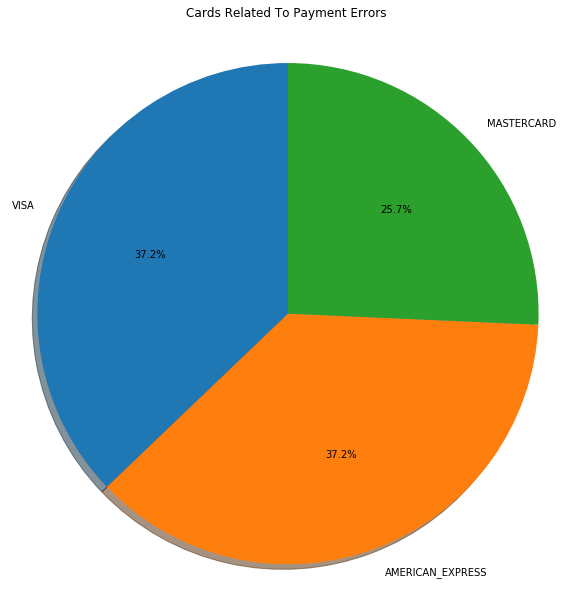

In [167]:
plot_counter(payment_error_counter, "Cards Related To Payment Errors")

## Lets do that again but take out decline

In [168]:
payment_errors_without_decline = [x for x in channel_history if is_payment_error(x) and x['error_key'] != 'DECLINED']
payment_error_counter = Counter([f"{x['card_type']}" for x in payment_errors_without_decline])

In [169]:
payment_error_counter.most_common(10)

[('AMERICAN_EXPRESS', 82), ('VISA', 74), ('MASTERCARD', 30)]

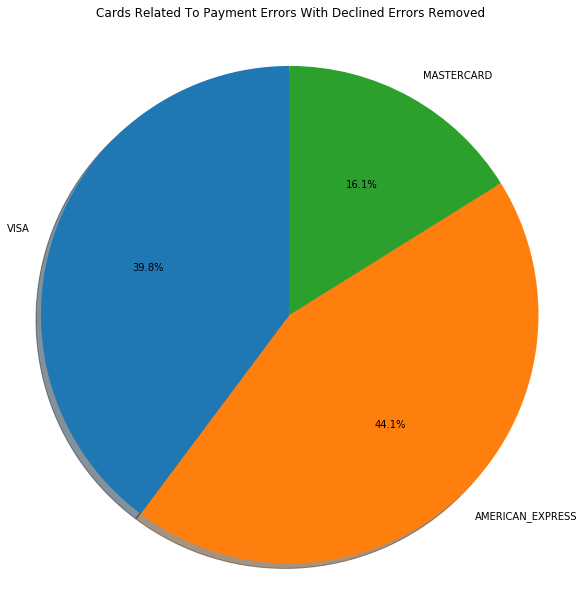

In [170]:
plot_counter(payment_error_counter, "Cards Related To Payment Errors With Declined Errors Removed")

## Finally, here is a table comparing Errors and successes for each card

|Card |% used in successful bookings | % involved in errors | % involved in errors other than 'DECLINED'|
|-------------|-------------|-------------|-------------|
|DISCOVER| 0.18%| 0.00%| 0.00%|
|MASTERCARD| 25.68%| 25.70%| 16.13%|
|VISA| 27.81%| 37.15%| 39.78%|
|AMERICAN_EXPRESS| 46.32%| 37.15%| 44.09%|